In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

In [3]:
def wavelength_to_rgb(wavelength, gamma=0.8):
    wavelength_nm = wavelength.astype(float) * 1e9
    R = np.zeros_like(wavelength_nm)
    G = np.zeros_like(wavelength_nm)
    B = np.zeros_like(wavelength_nm)
    mask1 = (wavelength_nm >= 380) & (wavelength_nm <= 440)
    mask2 = (wavelength_nm > 440) & (wavelength_nm <= 490)
    mask3 = (wavelength_nm > 490) & (wavelength_nm <= 510)
    mask4 = (wavelength_nm > 510) & (wavelength_nm <= 580)
    mask5 = (wavelength_nm > 580) & (wavelength_nm <= 645)
    mask6 = (wavelength_nm > 645) & (wavelength_nm <= 750)

    attenuation1 = 0.3 + 0.7 * (wavelength_nm[mask1] - 380) / (440 - 380)
    R[mask1] = ((-(wavelength_nm[mask1] - 440) / (440 - 380)) * attenuation1) ** gamma
    G[mask1] = 0.0
    B[mask1] = (1.0 * attenuation1) ** gamma

    R[mask2] = 0.0
    G[mask2] = ((wavelength_nm[mask2] - 440) / (490 - 440)) ** gamma
    B[mask2] = 1.0

    R[mask3] = 0.0
    G[mask3] = 1.0
    B[mask3] = (-(wavelength_nm[mask3] - 510) / (510 - 490)) ** gamma

    R[mask4] = ((wavelength_nm[mask4] - 510) / (580 - 510)) ** gamma
    G[mask4] = 1.0
    B[mask4] = 0.0

    R[mask5] = 1.0
    G[mask5] = (-(wavelength_nm[mask5] - 645) / (645 - 580)) ** gamma
    B[mask5] = 0.0
    
    attenuation6 = 0.3 + 0.7 * (750 - wavelength_nm[mask6]) / (750 - 645)
    R[mask6] = (1.0 * attenuation6) ** gamma
    G[mask6] = 0.0
    B[mask6] = 0.0

    return np.stack([R, G, B], axis=-1)


In [4]:
possible_wavelengths = np.array([645e-9, 510e-9, 440e-9])
possible_rgbs = wavelength_to_rgb(possible_wavelengths)

In [5]:
dx = 1e-4
dt = 1e-5

In [6]:
time_sample_length = 1
color_cycle_period = 1e-2
shake_amplitude = 0.01
shake_period = np.array([0, 1, 3, 10, 5 * (1 + 5 ** 0.5)]) * color_cycle_period
color_perception_window = 0.1

In [7]:
time = np.arange(0, time_sample_length, dt)
space = np.arange(0, shake_amplitude*2+dx, dx)
titles = list(f"Shake Period = {sp/color_cycle_period:.2f}$\\times$Color Cycle Period" for sp in shake_period)

In [8]:
light_x = (np.sin(2 * np.pi / shake_period[:, np.newaxis] * time[np.newaxis]) + 1) * shake_amplitude
color_idx = np.round((time / color_cycle_period) * len(possible_wavelengths)).astype(int) % len(possible_wavelengths)
light_wavelength = possible_wavelengths[color_idx]

/tmp/ipykernel_75434/2046543668.py:1: RuntimeWarning: divide by zero encountered in true_divide
  light_x = (np.sin(2 * np.pi / shake_period[:, np.newaxis] * time[np.newaxis]) + 1) * shake_amplitude
/tmp/ipykernel_75434/2046543668.py:1: RuntimeWarning: invalid value encountered in multiply
  light_x = (np.sin(2 * np.pi / shake_period[:, np.newaxis] * time[np.newaxis]) + 1) * shake_amplitude
/tmp/ipykernel_75434/2046543668.py:1: RuntimeWarning: invalid value encountered in sin
  light_x = (np.sin(2 * np.pi / shake_period[:, np.newaxis] * time[np.newaxis]) + 1) * shake_amplitude


In [9]:
def rle(inarray):
        """ run length encoding. Partial credit to R rle function. 
            Multi datatype arrays catered for including non Numpy
            returns: tuple (runlengths, startpositions, values) """
        ia = np.asarray(inarray)                # force numpy
        n = len(ia)
        if n == 0: 
            return (None, None, None)
        else:
            y = ia[1:] != ia[:-1]               # pairwise unequal (string safe)
            i = np.append(np.where(y), n - 1)   # must include last element posi
            z = np.diff(np.append(-1, i))       # run lengths
            p = np.cumsum(np.append(0, z))[:-1] # positions
            return(z, p, ia[i])

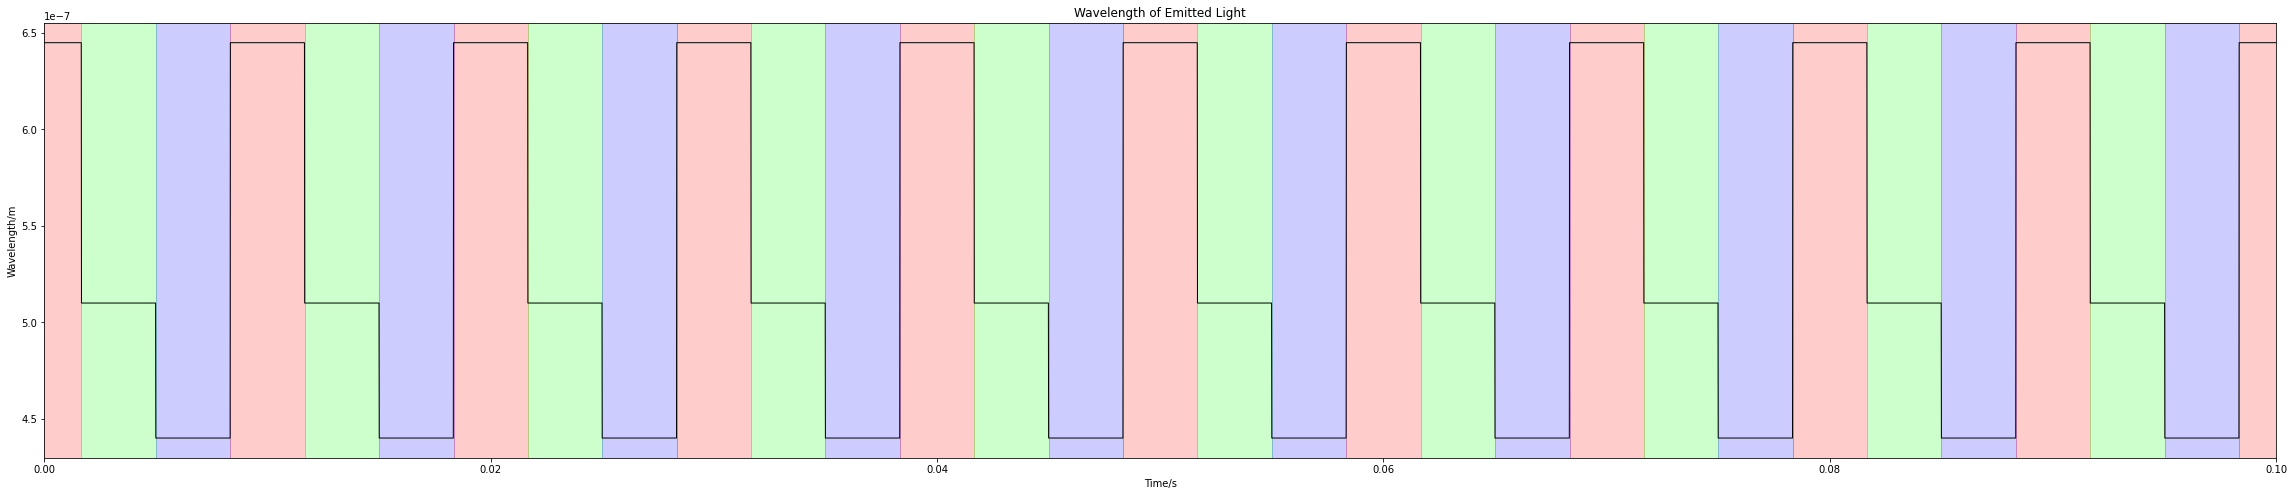

In [10]:
fig, ax = plt.subplots(figsize=(40, 8))
x_lim = min(time_sample_length, 10*color_cycle_period)
ax.set_xlim(right=x_lim)

r = rle(color_idx)
for i, l in enumerate(r[1][:-1]):
    c_idx = r[2][i]
    c_shade = possible_rgbs[c_idx]
    start = l * dt
    end = r[1][i+1] * dt
    ax.axvspan(start, end, color=c_shade, alpha=0.2)
    if end >= x_lim:
        break

ax.plot(time, light_wavelength, c="black", linewidth=1)
ax.set_title("Wavelength of Emitted Light")
ax.set_xlabel("Time/s")
ax.set_ylabel("Wavelength/m");

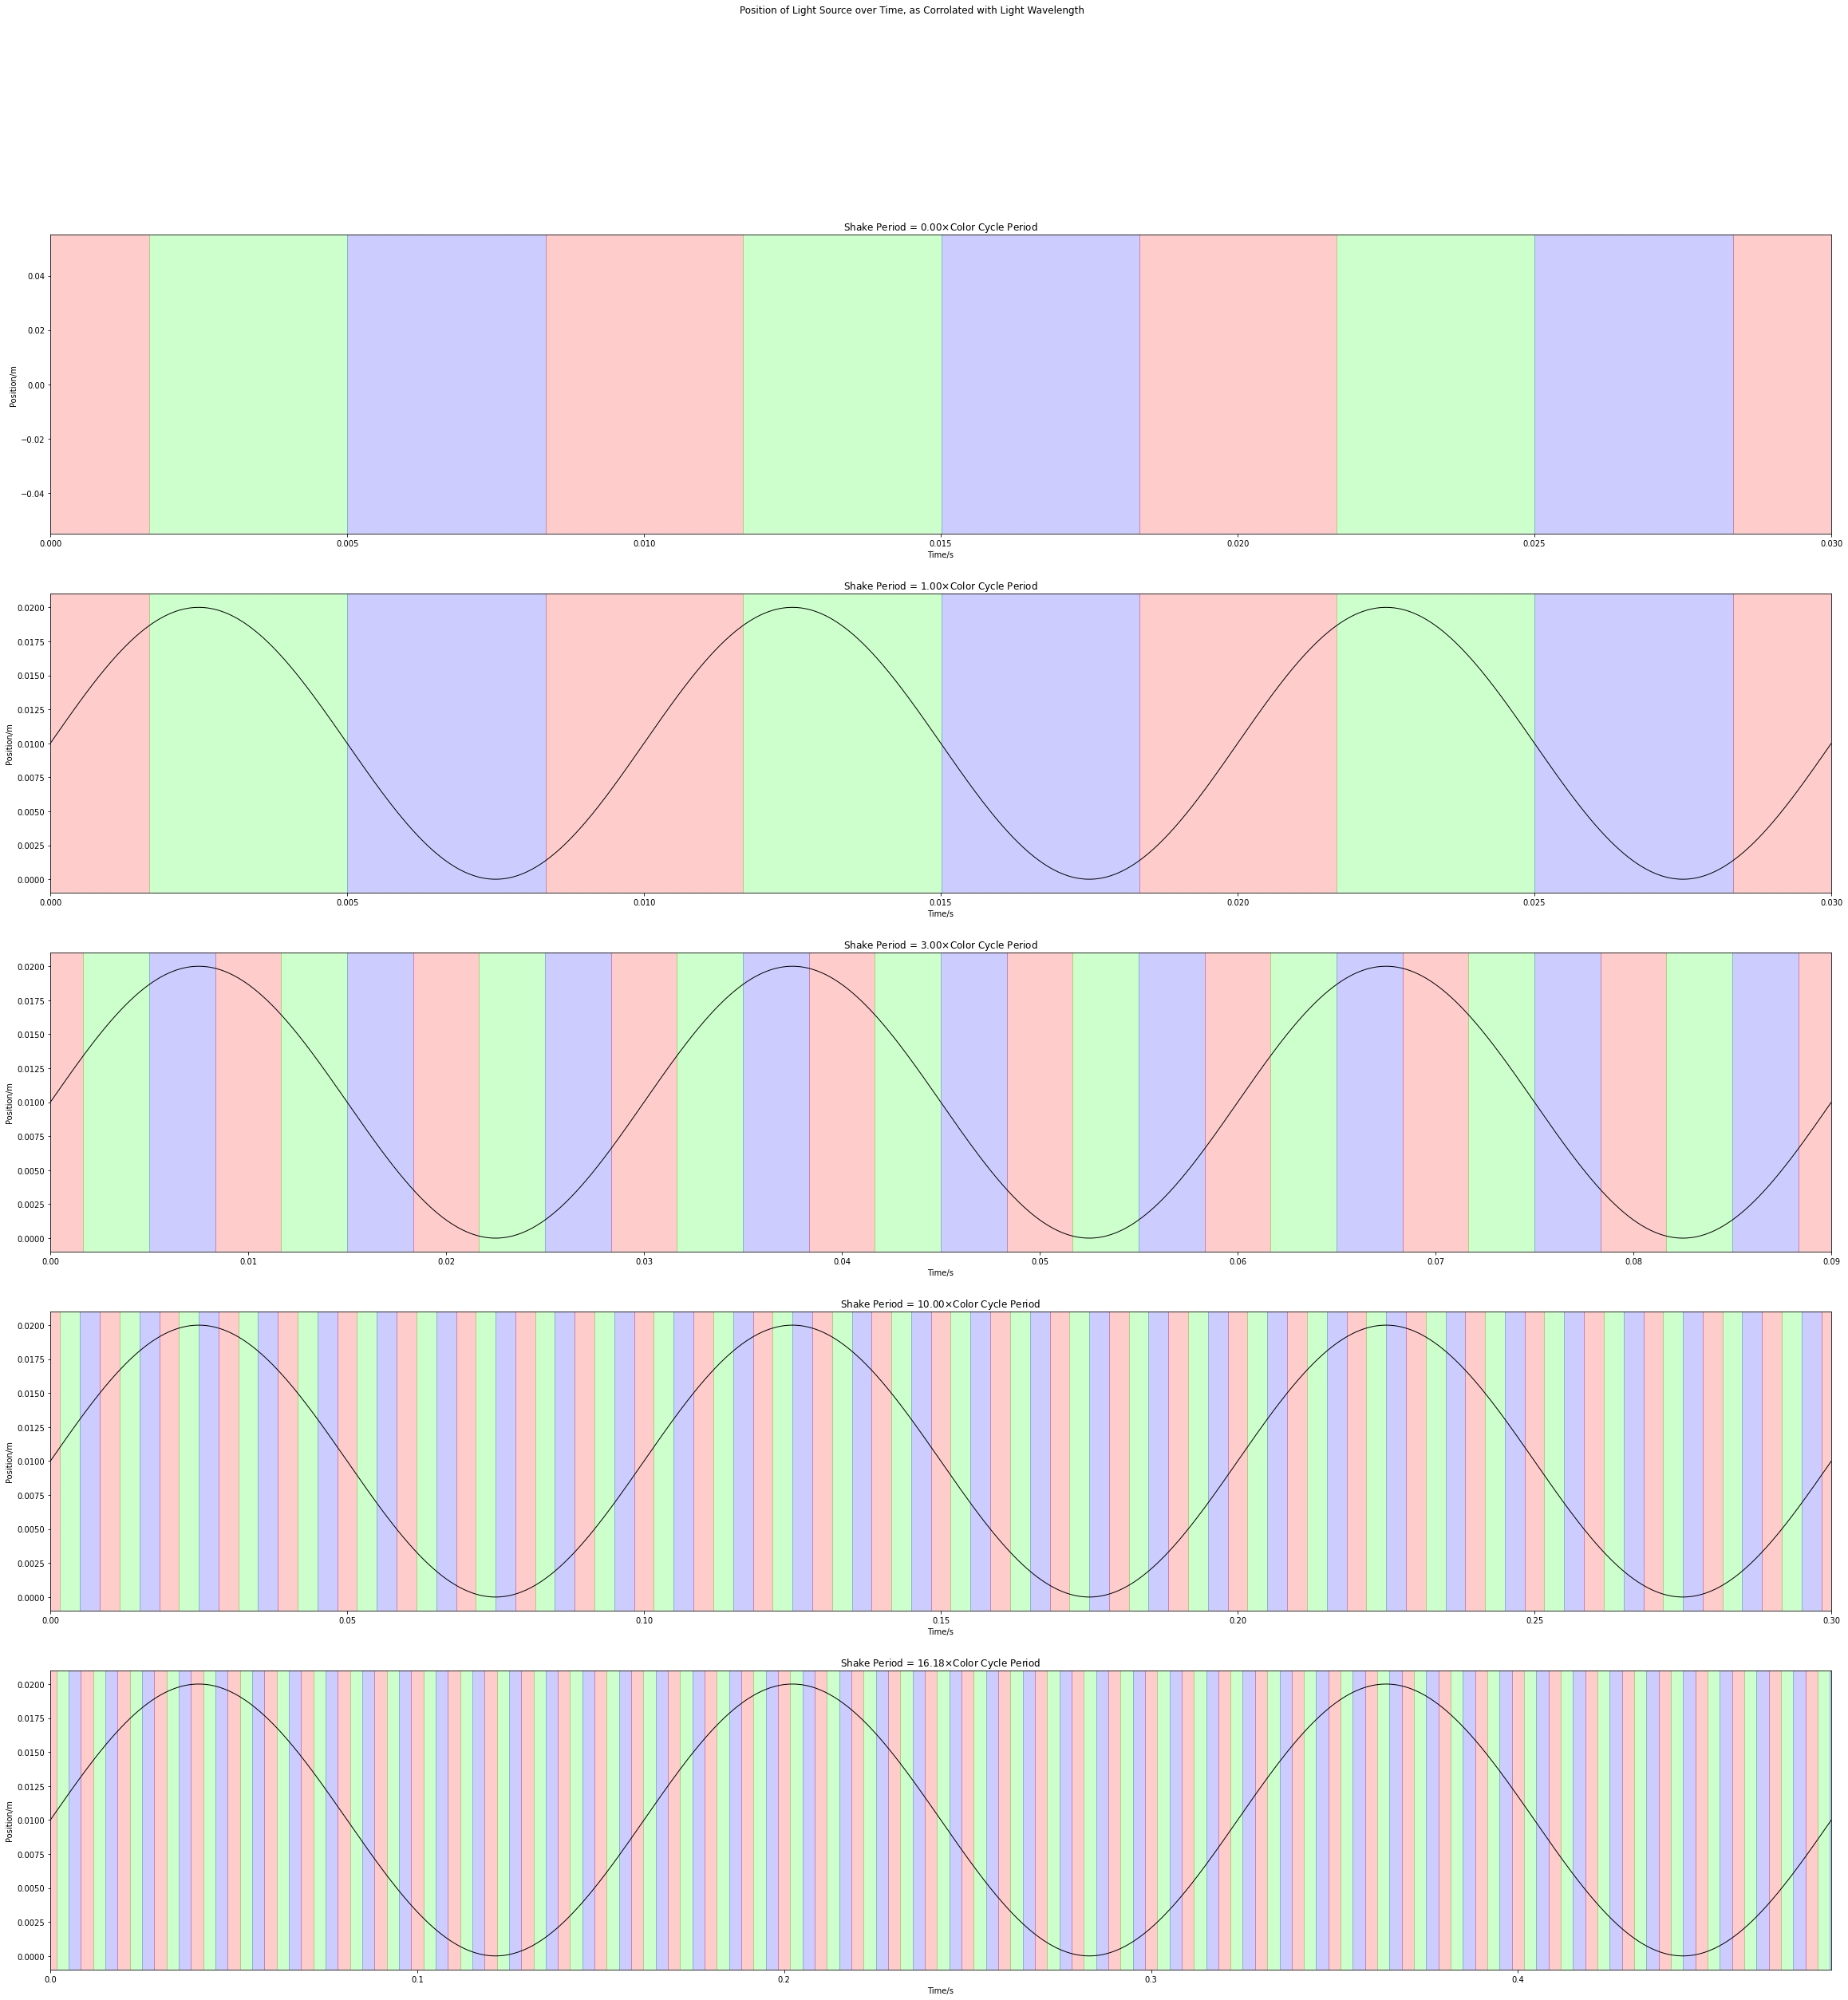

In [11]:
fig, axs = plt.subplots(len(shake_period), figsize=(40, 8*len(shake_period)))
fig.suptitle("Position of Light Source over Time, as Corrolated with Light Wavelength")

for i, sp in enumerate(shake_period):
    ax = axs[i]
    x_lim = min(time_sample_length, max(sp*3, color_cycle_period*3))
    ax.set_xlim(right=x_lim)

    r = rle(color_idx)
    for j, l in enumerate(r[1][:-1]):
        c_idx = r[2][j]
        c_shade = possible_rgbs[c_idx]
        start = l * dt
        end = r[1][j+1] * dt
        ax.axvspan(start, end, color=c_shade, alpha=0.2)
        if end >= x_lim:
            break

    ax.plot(time, light_x[i], c="black", linewidth=1)
    ax.set_title(titles[i])
    ax.set_xlabel("Time/s")
    ax.set_ylabel("Position/m");

In [12]:
dist_wavelengths = np.zeros((len(shake_period), len(time), len(space))) + np.nan
xs = []
ys = []
cs = []

for i, lx in enumerate(light_x):

    xs_ = []
    ys_ = []
    cs_ = []

    light_x_idx = np.round(lx/dx).astype(int)
    for t_idx, curr in enumerate(light_x_idx):
        prv = light_x_idx[(t_idx-1) if t_idx > 0 else t_idx]
        nxt = light_x_idx[(t_idx+1) if t_idx < len(time)-1 else t_idx]
        prv, nxt = min(prv, nxt), max(prv, nxt)
        assert prv <= curr <= nxt
        dist_wavelengths[i, t_idx, prv:nxt+1] = light_wavelength[t_idx]
        xs_.append(curr * dx)
        ys_.append(t_idx * dt)
        cs_.append(np.where(possible_wavelengths == light_wavelength[t_idx])[0][0])

    xs.append(xs_)
    ys.append(ys_)
    cs.append(cs_)

xs = np.array(xs)
ys = np.array(ys)
cs = np.array(cs)


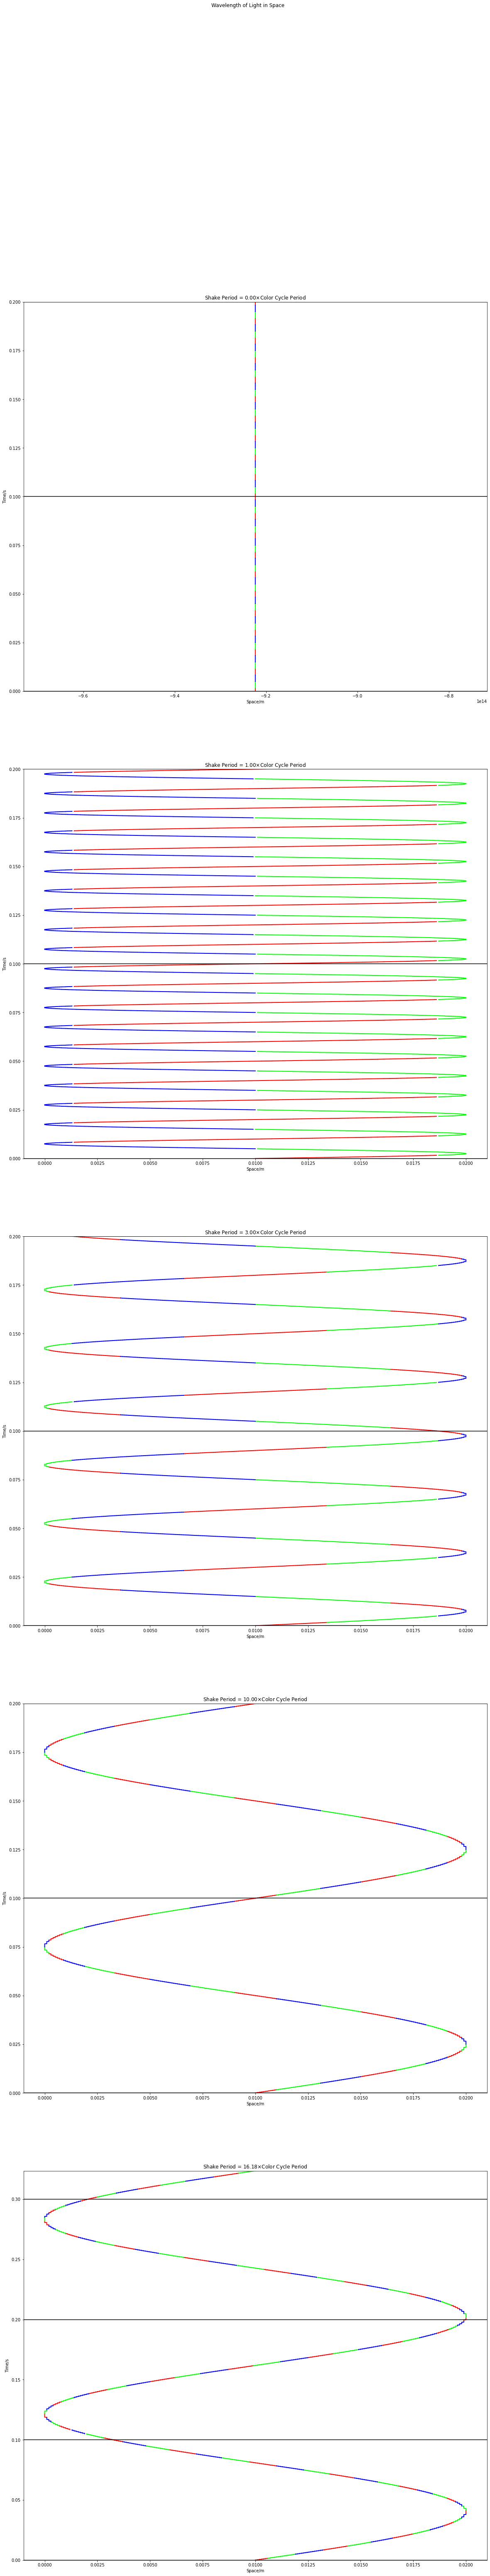

In [13]:
fig, axs = plt.subplots(len(shake_period), figsize=(20, 20*len(shake_period)))
fig.suptitle("Wavelength of Light in Space")

for i, sp in enumerate(shake_period):
    ax = axs[i]
    ylim = min(time_sample_length, max(2*color_perception_window, 2*sp, 2*color_cycle_period))
    ax.set_ylim(top=ylim)

    for j, c in enumerate(possible_rgbs):
        mask = cs[i] == j
        ax.plot(np.where(mask, xs[i], np.nan), np.where(mask, ys[i], np.nan), color=c, linewidth=2)

    for t in np.arange(0, time_sample_length, color_perception_window):
        ax.axhline(t, color="black")

    ax.set_title(titles[i])
    ax.set_xlabel("Space/m")
    ax.set_ylabel("Time/s")

In [14]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


In [15]:
dist_rgbs = wavelength_to_rgb(dist_wavelengths)
avgs = []
for i in range(len(shake_period)):
    avgs_ = []
    n = int(round(color_perception_window/dt))
    for x_idx in range(len(space)):
        time_series = dist_rgbs[i, :, x_idx]
        avg = np.stack(list(moving_average(time_series[:, j], n=n) for j in range(3)), axis=-1)
        avgs_.append(avg)
    avgs.append(avgs_)

average_rgbs = np.array(avgs).swapaxes(1, 2)

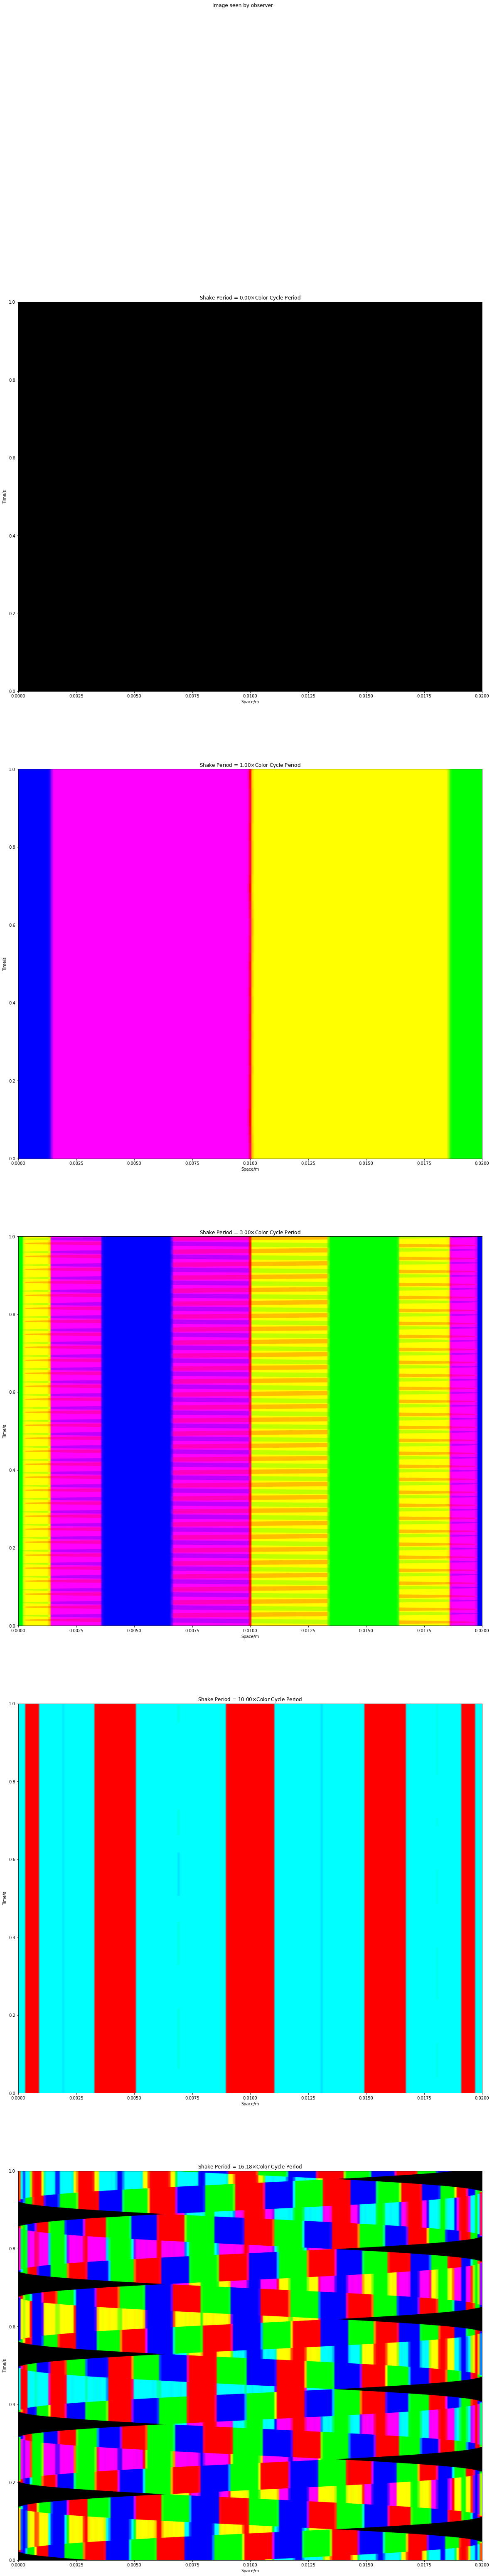

In [16]:
hsv = mpl.colors.rgb_to_hsv(average_rgbs)
hsv[:, :,:,1:] = 1
rgb = mpl.colors.hsv_to_rgb(hsv)
rgb[np.sum(average_rgbs, axis=-1) == 0] = 0

fig, axs = plt.subplots(len(shake_period), figsize=(20, 20*len(shake_period)))
fig.suptitle("Image seen by observer")
for i, rgb_ in enumerate(rgb):
    ax = axs[i]
    ax.imshow(rgb_, aspect="auto", extent=(0, 2*shake_amplitude, 0, time_sample_length), origin="lower")

    ax.set_title(titles[i])
    ax.set_xlabel("Space/m")
    ax.set_ylabel("Time/s")